# **Pre-requisites**

In [1]:
import numpy as np
import pandas as pd
import random
import os
import cv2
import PIL
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import tensorflow as tf
import itertools
from pathlib import Path
import keras
import imagesize
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from keras import Model, layers
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import torch
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

# **One time execution**

In [ ]:
#import splitfolders

In [ ]:
#!pip install -q split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
'''
def split():
    data_dir = os.path.join('/content/drive/MyDrive/data_categorised_rgb')
    print("No of images in each class of data directory")
    for dir, subdir, files in os.walk(data_dir):
        print(dir,':', str(len(files)))
        
    splitfolders.ratio("/content/drive/MyDrive/data_categorised_rgb", 
                       output = "/content/drive/MyDrive",
                       seed = 6, 
                       ratio = (0.7, 0.2, 0.1), 
                       group_prefix = None, 
                       move = False)

if os.path.exists("/content/drive/MyDrive/multiclass_data_folders/train"):
    print("Files already present in splitted format")
else:
    split()
    print("Files are splitted in the ratio 0.8, 0.2")
'''

Files already present in splitted format


In [ ]:
dir_path = '/content/drive/MyDrive/multiclass_augmented/'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('Augmented File count:', count)

# **Utility Function**

In [12]:
def plot_accuracy_from_history(history, isinception = False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

In [13]:
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

In [14]:
def do_history_stuff(history, history_file_name, isinception=False):
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [15]:
def show_few_images(number_of_examples = 2, predict_using_model = None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            display = plt.imread(os.path.join(train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

In [16]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    print(classification_report(true_value, model_pred, target_names = list(classes)))

# **Data Preparation**

In [17]:
train_folders = '/content/drive/MyDrive/multiclass_data_folders/train'
val_folders = '/content/drive/MyDrive/multiclass_data_folders/val'

In [18]:
sum = 0
data_dir = os.path.join("/content/drive/MyDrive/multiclass_data_folders")
print("No of images in each class of the directory")
for dir, subdir, files in os.walk(data_dir):
    if len(files) == 0:
        continue
    else:
        print(dir, ':', str(len(files)))
        sum += len(files)
print("Total no of images:", sum)

No of images in each class of the directory
/content/drive/MyDrive/multiclass_data_folders/train/CS(40-50) : 316
/content/drive/MyDrive/multiclass_data_folders/train/D(20-25) : 281
/content/drive/MyDrive/multiclass_data_folders/train/DD(30-35) : 427
/content/drive/MyDrive/multiclass_data_folders/train/SevereCS(55-65) : 205
/content/drive/MyDrive/multiclass_data_folders/train/VSCS(70-90) : 244
/content/drive/MyDrive/multiclass_data_folders/val/CS(40-50) : 80
/content/drive/MyDrive/multiclass_data_folders/val/D(20-25) : 71
/content/drive/MyDrive/multiclass_data_folders/val/DD(30-35) : 107
/content/drive/MyDrive/multiclass_data_folders/val/SevereCS(55-65) : 52
/content/drive/MyDrive/multiclass_data_folders/val/VSCS(70-90) : 61
Total no of images: 1844


In [19]:
#checking the resolution of a random image to find desired target size
root = data_dir + "/train/VSCS(70-90)/"

imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis = 'columns', inplace = False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index = img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total number of images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total number of images in the dataset: 244


,FileName,Size,Width,Height,Aspect Ratio
0,20001226.06-75.jpg,"(332, 340)",332,340,0.98
1,20001128.15-90.jpg,"(333, 339)",333,339,0.98
2,20001227.06-75.jpg,"(335, 339)",335,339,0.99
3,20010523.12-90.jpg,"(333, 339)",333,339,0.98
4,20010523.09-90.jpg,"(332, 340)",332,340,0.98


In [20]:
#check if any image file height is more than 350
temp_df = img_meta_df[img_meta_df['Height'] > 350]
temp_df.head()

,FileName,Size,Width,Height,Aspect Ratio


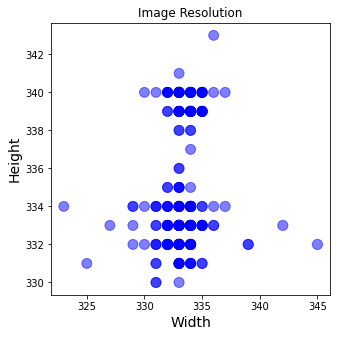

In [21]:
# Visualize Image Resolutions
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color = 'blue', alpha = 0.5, s = img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size = 14)
ax.set_ylabel("Height", size = 14);

We are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance.
We are only normalising to make the prediction, the other parameters were used for agumentation and train weights

In [22]:
train_datagen = ImageDataGenerator(rescale = 1.0/255., rotation_range = 10)
train_generator = train_datagen.flow_from_directory(train_folders, batch_size = 2, class_mode = 'categorical', target_size = (310, 310))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) 
validation_generator = validation_datagen.flow_from_directory(val_folders, batch_size = 1, class_mode = 'categorical', target_size = (310, 310), shuffle = False)

Found 1473 images belonging to 5 classes.
Found 371 images belonging to 5 classes.


In [23]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'CS(40-50)': 0, 'D(20-25)': 1, 'DD(30-35)': 2, 'SevereCS(55-65)': 3, 'VSCS(70-90)': 4}
{0: 'CS(40-50)', 1: 'D(20-25)', 2: 'DD(30-35)', 3: 'SevereCS(55-65)', 4: 'VSCS(70-90)'}


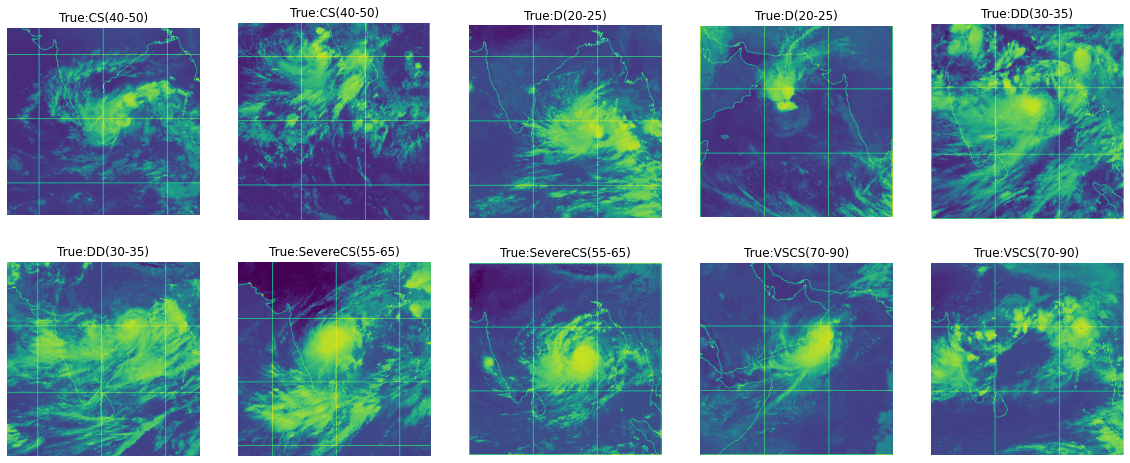

In [24]:
show_few_images(2)

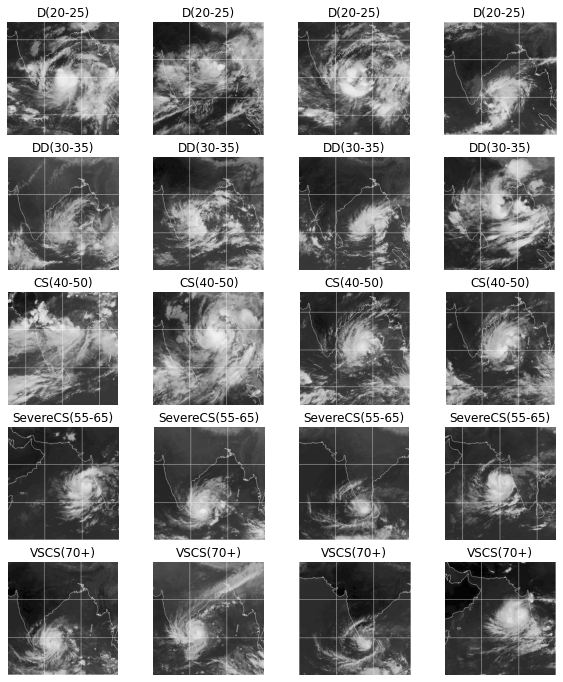

In [25]:
plt.figure(figsize = (10, 12))
plt.tight_layout()
classes_dict = {
    0 : 'D(20-25)',
    1 : 'DD(30-35)',
    2 : 'CS(40-50)',
    3 : 'SevereCS(55-65)',
    4 : 'VSCS(70+)'
}
for i,folder in enumerate(os.listdir(train_folders)):
    path = os.path.join(train_folders,folder)
    img_ls = os.listdir(path)
    for j,im_name in enumerate(img_ls[:4]):
        plt.subplot(5, 4, 4 * i+j+1)
        img_path = os.path.join(path, im_name)
        img = PIL.Image.open(img_path)
        plt.imshow(img, cmap = 'gray')
        plt.axis("off")
        plt.title(classes_dict[int(i)])
        plt.savefig('xyz')

In [26]:
vgg_epoch = 30
resnet_epoch = 15
inception_epoch = 20

# **VGG-16 Model**

In [ ]:
tf.keras.backend.clear_session()

Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 2. Images of size each 150x150 with 3 color channels will be input into this layer

In [ ]:
vgg16_model = VGG16(pooling = 'avg', weights = 'imagenet', include_top = False, input_shape = (310, 310, 3))
for layers in vgg16_model.layers:
  layers.trainable = False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(5, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = [f1, 'acc'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

In [ ]:
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = vgg16_final_model.fit(train_generator, epochs = vgg_epoch, validation_data = validation_generator, callbacks = [checkpoint, early_stopping], verbose = 1)

In [ ]:
vgg16_final_model.save('/content/drive/MyDrive/multiclass_vgg_model.hdf5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


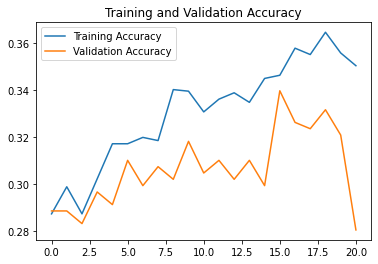

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


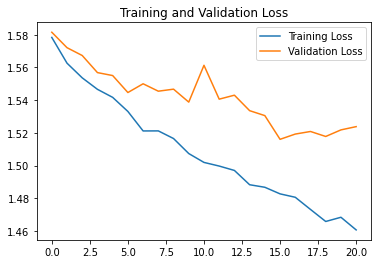

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


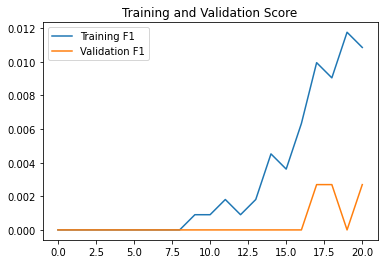

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(history, 'vgg16_model')

In [ ]:
vgg_best_model = vgg16_final_model
true_value = []
vgg_pred = []
for folder in os.listdir(val_folders):
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    for image_id in val_image_ids[:int(len(val_image_ids))]:
        path = os.path.join(val_folders, folder, image_id)
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310, 310))
        img_normalized = img/255
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center", color="black" if cm[i,j] > thresh else "white")
        pass
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.33962264150943394
                 precision    recall  f1-score   support

      CS(40-50)       0.32      0.31      0.32        80
       D(20-25)       0.31      0.55      0.40        71
      DD(30-35)       0.41      0.30      0.34       107
SevereCS(55-65)       0.10      0.02      0.03        52
    VSCS(70-90)       0.36      0.48      0.41        61

       accuracy                           0.34       371
      macro avg       0.30      0.33      0.30       371
   weighted avg       0.32      0.34      0.32       371



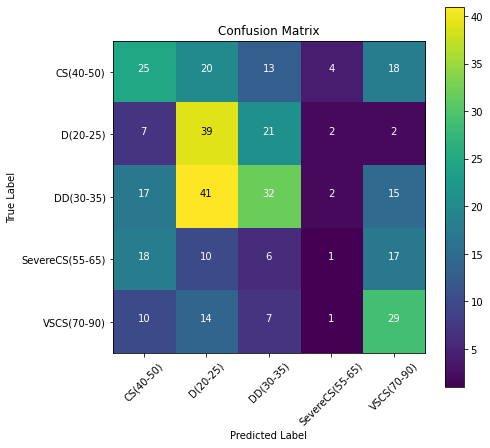

In [ ]:
clf_report(true_value, vgg_pred)

# **ResNet-50 Model**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top = False, input_shape = (310,310,3), classes=5)
for layers in ResNet50_model.layers:
    layers.trainable = True

# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(5,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs = ResNet50_model.input, outputs = resnet50_x)

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['acc'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.05, patience = 5, min_lr = 0.00002)

In [ ]:
history = resnet50_x_final_model.fit(train_generator, epochs = resnet_epoch, validation_data = validation_generator,
                                              callbacks= [early_stopping,reduce_lr], verbose=1)

Epoch 1/15
737/737 [==============================] - 724s 955ms/step - loss: 2.1987 - acc: 0.3530 - val_loss: 1.6916 - val_acc: 0.2480 - lr: 1.0000e-04
Epoch 2/15
737/737 [==============================] - 65s 88ms/step - loss: 1.1808 - acc: 0.5160 - val_loss: 1.5947 - val_acc: 0.4340 - lr: 1.0000e-04
Epoch 3/15
737/737 [==============================] - 64s 86ms/step - loss: 0.9198 - acc: 0.6286 - val_loss: 1.3304 - val_acc: 0.5148 - lr: 1.0000e-04
Epoch 4/15
737/737 [==============================] - 63s 86ms/step - loss: 0.7219 - acc: 0.7305 - val_loss: 1.4434 - val_acc: 0.5418 - lr: 1.0000e-04
Epoch 5/15
737/737 [==============================] - 64s 87ms/step - loss: 0.6264 - acc: 0.7746 - val_loss: 1.4513 - val_acc: 0.5094 - lr: 1.0000e-04
Epoch 6/15
737/737 [==============================] - 63s 86ms/step - loss: 0.5180 - acc: 0.8113 - val_loss: 2.4747 - val_acc: 0.4798 - lr: 1.0000e-04
Epoch 7/15
737/737 [==============================] - 63s 86ms/step - loss: 0.3871 - acc: 0.

In [ ]:
resnet50_x_final_model.save('/content/drive/MyDrive/multiclass_resnet_model.hdf5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


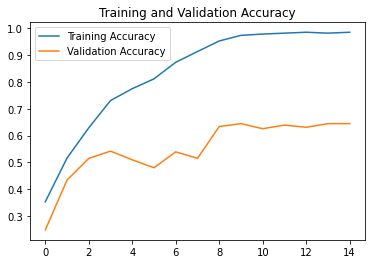

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


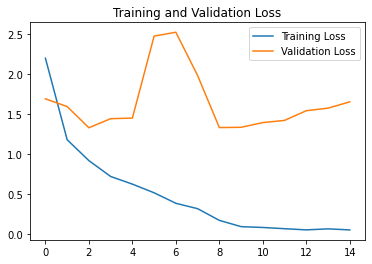

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(history, 'resnet50_model')

In [ ]:
resnet_best_model = resnet50_x_final_model
resnet_pred = []
true_value = []
for folder in os.listdir(val_folders):
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    for image_id in val_image_ids[:int(len(val_image_ids))]:
        path = os.path.join(val_folders,folder,image_id)
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.6415094339622641
                 precision    recall  f1-score   support

      CS(40-50)       0.46      0.61      0.53        80
       D(20-25)       0.69      0.62      0.65        71
      DD(30-35)       0.71      0.69      0.70       107
SevereCS(55-65)       0.59      0.50      0.54        52
    VSCS(70-90)       0.85      0.74      0.79        61

       accuracy                           0.64       371
      macro avg       0.66      0.63      0.64       371
   weighted avg       0.66      0.64      0.65       371



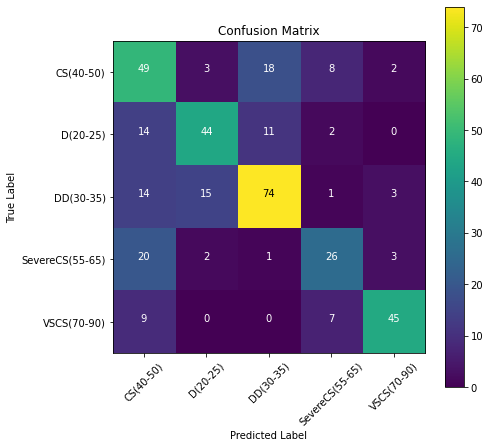

In [ ]:
clf_report(true_value, resnet_pred)

# **AlexNet**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(BatchNormalization())
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
num_classes = 5
model = AlexNet((310, 310, 3), num_classes)

In [ ]:
model.fit(train_generator, epochs=15, validation_data=validation_generator, verbose=1)

Epoch 1/15
737/737 [==============================] - 44s 59ms/step - loss: 2.0127 - accuracy: 0.2926 - val_loss: 1.5918 - val_accuracy: 0.2884
Epoch 2/15
737/737 [==============================] - 43s 58ms/step - loss: 1.9827 - accuracy: 0.2790 - val_loss: 1.5790 - val_accuracy: 0.2884
Epoch 3/15
737/737 [==============================] - 42s 57ms/step - loss: 1.5812 - accuracy: 0.2899 - val_loss: 1.5784 - val_accuracy: 0.2884
Epoch 4/15
737/737 [==============================] - 41s 56ms/step - loss: 1.5809 - accuracy: 0.2899 - val_loss: 1.5787 - val_accuracy: 0.2884
Epoch 5/15
737/737 [==============================] - 42s 57ms/step - loss: 1.5807 - accuracy: 0.2899 - val_loss: 1.5790 - val_accuracy: 0.2884
Epoch 6/15
737/737 [==============================] - 43s 58ms/step - loss: 1.5808 - accuracy: 0.2899 - val_loss: 1.5781 - val_accuracy: 0.2884
Epoch 7/15
737/737 [==============================] - 42s 57ms/step - loss: 1.5799 - accuracy: 0.2899 - val_loss: 1.5790 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/multiclass_alexnet_model.hdf5')

In [ ]:
resnet_best_model = model
resnet_pred = []
true_value = []
for folder in os.listdir(val_folders):
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    for image_id in val_image_ids[:int(len(val_image_ids))]:
        path = os.path.join(val_folders,folder,image_id)
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)

1/1 [==============================] - 0s 22ms/step


In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.2884097035040431
                 precision    recall  f1-score   support

      CS(40-50)       0.00      0.00      0.00        80
       D(20-25)       0.00      0.00      0.00        71
      DD(30-35)       0.29      1.00      0.45       107
SevereCS(55-65)       0.00      0.00      0.00        52
    VSCS(70-90)       0.00      0.00      0.00        61

       accuracy                           0.29       371
      macro avg       0.06      0.20      0.09       371
   weighted avg       0.08      0.29      0.13       371



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


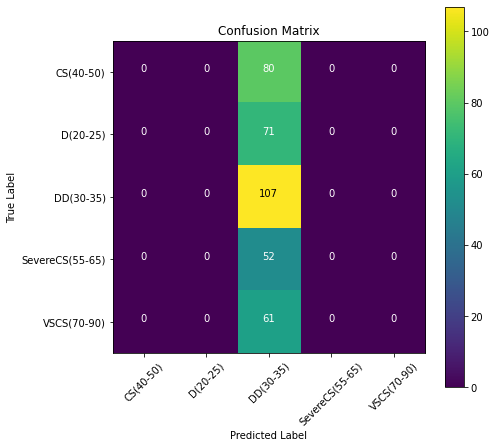

In [ ]:
clf_report(true_value, resnet_pred)

# **Inceptionv3 Model**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
InceptionV3_model = InceptionV3(input_shape = (310, 310, 3), weights = 'imagenet', include_top = False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True

InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation = 'relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(5, activation = 'softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs = InceptionV3_model.input, outputs = InceptionV3_x)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
InceptionV3_x_final_model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['acc', f1])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

In [ ]:
history = InceptionV3_x_final_model.fit(train_generator, epochs = inception_epoch, validation_data = validation_generator, callbacks = [early_stopping], verbose=1)

Epoch 1/20
737/737 [==============================] - 64s 78ms/step - loss: 3.1523 - acc: 0.2756 - f1: 0.1036 - val_loss: 1.4652 - val_acc: 0.3639 - val_f1: 0.0270
Epoch 2/20
737/737 [==============================] - 55s 74ms/step - loss: 1.5284 - acc: 0.3204 - f1: 0.0805 - val_loss: 1.4185 - val_acc: 0.3774 - val_f1: 0.0863
Epoch 3/20
737/737 [==============================] - 54s 74ms/step - loss: 1.4636 - acc: 0.3462 - f1: 0.1156 - val_loss: 1.3389 - val_acc: 0.3854 - val_f1: 0.1078
Epoch 4/20
737/737 [==============================] - 54s 74ms/step - loss: 1.4316 - acc: 0.3646 - f1: 0.1771 - val_loss: 1.3312 - val_acc: 0.4205 - val_f1: 0.1024
Epoch 5/20
737/737 [==============================] - 54s 73ms/step - loss: 1.3103 - acc: 0.4168 - f1: 0.2205 - val_loss: 1.3188 - val_acc: 0.4394 - val_f1: 0.2129
Epoch 6/20
737/737 [==============================] - 59s 80ms/step - loss: 1.2348 - acc: 0.4460 - f1: 0.2551 - val_loss: 1.2491 - val_acc: 0.4663 - val_f1: 0.1995
Epoch 7/20
737/7

In [ ]:
InceptionV3_x_final_model.save('/content/drive/MyDrive/multiclass_inception_model.hdf5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


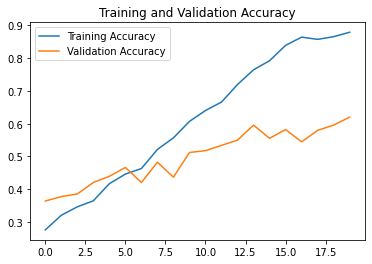

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


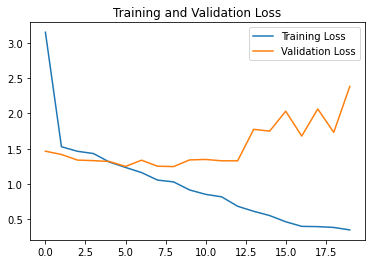

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


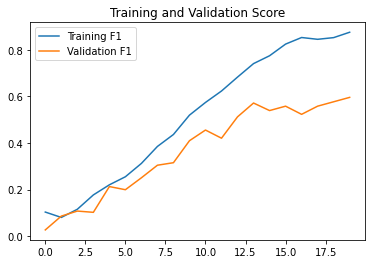

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(history, 'inceptionv3_model', True)

In [ ]:
inception_best_model = InceptionV3_x_final_model
true_value = []
inception_pred = []
for folder in os.listdir(val_folders):
    test_image_ids = os.listdir(os.path.join(val_folders,folder))
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        path = os.path.join(val_folders,folder,image_id)
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.6064690026954178
                 precision    recall  f1-score   support

      CS(40-50)       0.53      0.64      0.58        80
       D(20-25)       0.70      0.56      0.62        71
      DD(30-35)       0.69      0.62      0.65       107
SevereCS(55-65)       0.46      0.48      0.47        52
    VSCS(70-90)       0.64      0.70      0.67        61

       accuracy                           0.61       371
      macro avg       0.60      0.60      0.60       371
   weighted avg       0.62      0.61      0.61       371



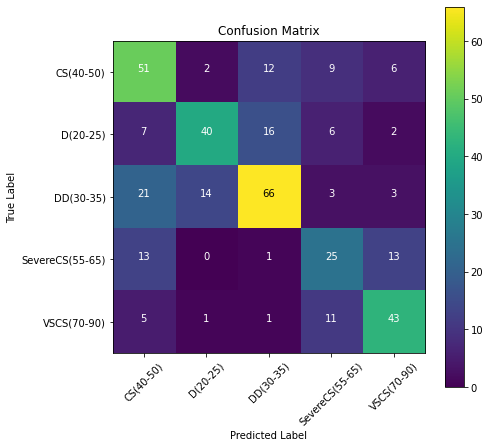

In [ ]:
clf_report(true_value, inception_pred)

# **XceptionNet**

In [ ]:
from tensorflow.keras.applications.xception import Xception
xception_model = Xception(include_top = False, weights = "imagenet", input_shape = (310, 310, 3))
x = Flatten()(xception_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(5, activation = 'softmax')(x)

xception_final_model = Model(inputs = xception_model.input, outputs = x)

In [ ]:
xception_final_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 7)

In [ ]:
history = xception_final_model.fit(train_generator, epochs = 30, validation_data = validation_generator, callbacks = [early_stopping], verbose=1)

Epoch 1/30
737/737 [==============================] - 141s 184ms/step - loss: 1.7604 - acc: 0.2688 - val_loss: 1.6036 - val_acc: 0.2695
Epoch 2/30
737/737 [==============================] - 92s 124ms/step - loss: 1.7784 - acc: 0.2695 - val_loss: 1.7321 - val_acc: 0.2668
Epoch 3/30
737/737 [==============================] - 91s 123ms/step - loss: 1.7609 - acc: 0.2736 - val_loss: 1.9613 - val_acc: 0.2884
Epoch 4/30
737/737 [==============================] - 89s 121ms/step - loss: 1.6053 - acc: 0.2946 - val_loss: 2.8227 - val_acc: 0.2857
Epoch 5/30
737/737 [==============================] - 90s 123ms/step - loss: 1.6541 - acc: 0.2811 - val_loss: 1.5802 - val_acc: 0.2884
Epoch 6/30
737/737 [==============================] - 91s 123ms/step - loss: 1.6289 - acc: 0.2790 - val_loss: 1.5996 - val_acc: 0.2884
Epoch 7/30
737/737 [==============================] - 89s 121ms/step - loss: 1.6431 - acc: 0.2783 - val_loss: 7.7023 - val_acc: 0.2588
Epoch 8/30
737/737 [==============================] - 

In [ ]:
xception_final_model.save('/content/drive/MyDrive/multiclass_xception_model.hdf5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


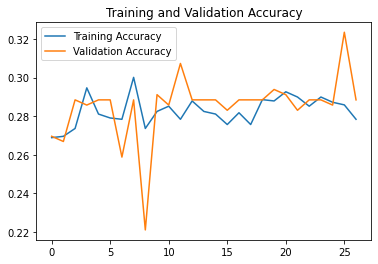

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


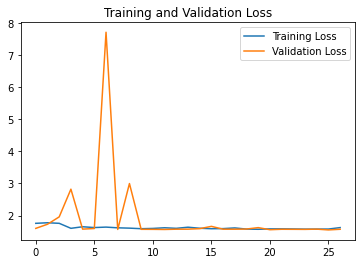

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(history, 'xception_model', True)

In [ ]:
xception_best_model = xception_final_model
true_value = []
inception_pred = []
for folder in os.listdir(val_folders):
    test_image_ids = os.listdir(os.path.join(val_folders,folder))
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        path = os.path.join(val_folders,folder,image_id)
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255
        inception_image_prediction = np.argmax(xception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

1/1 [==============================] - 0s 23ms/step


In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.2884097035040431
                 precision    recall  f1-score   support

      CS(40-50)       0.00      0.00      0.00        80
       D(20-25)       0.00      0.00      0.00        71
      DD(30-35)       0.29      1.00      0.45       107
SevereCS(55-65)       0.00      0.00      0.00        52
    VSCS(70-90)       0.00      0.00      0.00        61

       accuracy                           0.29       371
      macro avg       0.06      0.20      0.09       371
   weighted avg       0.08      0.29      0.13       371



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


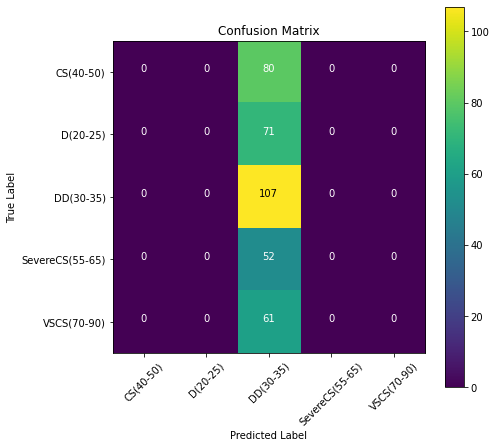

In [ ]:
clf_report(true_value, inception_pred)

# **Proposed Model**

In [ ]:
keras.backend.clear_session()

In [ ]:
own_model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), input_shape = (310, 310, 3), activation = 'relu', name = 'Conv1'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', name = 'Conv2'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', name = 'Conv3'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', name = 'Conv4'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Flatten(),

tf.keras.layers.Dropout(0.4),

tf.keras.layers.Dense(units = 512, activation = 'relu'),

tf.keras.layers.Dropout(0.3),

tf.keras.layers.Dense(5, activation = 'softmax')
])

In [ ]:
own_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.05, patience = 5, min_lr = 0.00002)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience=3)

In [ ]:
history = own_model.fit(train_generator, epochs = 30, verbose = 1, validation_data = validation_generator, callbacks = [reduce_lr, early_stopping])

Epoch 1/30
737/737 [==============================] - 37s 49ms/step - loss: 1.5995 - acc: 0.2783 - val_loss: 1.5856 - val_acc: 0.2938 - lr: 1.0000e-04
Epoch 2/30
737/737 [==============================] - 36s 48ms/step - loss: 1.5722 - acc: 0.3021 - val_loss: 1.5901 - val_acc: 0.2965 - lr: 1.0000e-04
Epoch 3/30
737/737 [==============================] - 36s 48ms/step - loss: 1.5270 - acc: 0.3177 - val_loss: 1.5805 - val_acc: 0.2803 - lr: 1.0000e-04
Epoch 4/30
737/737 [==============================] - 36s 48ms/step - loss: 1.4782 - acc: 0.3591 - val_loss: 1.5126 - val_acc: 0.3235 - lr: 1.0000e-04
Epoch 5/30
737/737 [==============================] - 36s 48ms/step - loss: 1.4444 - acc: 0.3788 - val_loss: 1.5436 - val_acc: 0.3450 - lr: 1.0000e-04
Epoch 6/30
737/737 [==============================] - 35s 48ms/step - loss: 1.4070 - acc: 0.3890 - val_loss: 1.4521 - val_acc: 0.4016 - lr: 1.0000e-04
Epoch 7/30
737/737 [==============================] - 36s 48ms/step - loss: 1.3426 - acc: 0.43

In [ ]:
own_model.save('/content/drive/MyDrive/multiclass_own_model.hdf5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


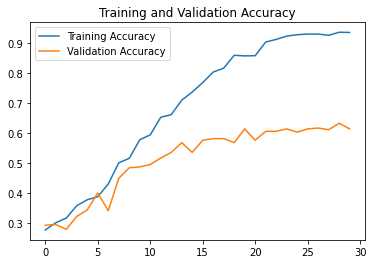

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


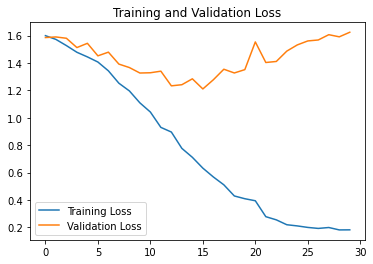

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(history, 'own_model')

In [ ]:
true_value = []
own_model_pred = []
for folder in os.listdir(val_folders):
  val_image_ids = os.listdir(os.path.join(val_folders,folder))
  
  for image_id in val_image_ids[:int(len(val_image_ids))]: 
      path = os.path.join(val_folders,folder,image_id)
      
      true_value.append(validation_generator.class_indices[folder])
      img = cv2.resize(cv2.imread(path),(310,310))
      img_normalized = img/255
      own_model_prediction = np.argmax(own_model.predict(np.array([img_normalized])))
      own_model_pred.append(own_model_prediction)

Model Accuracy 0.6145552560646901
                 precision    recall  f1-score   support

      CS(40-50)       0.53      0.51      0.52        80
       D(20-25)       0.77      0.56      0.65        71
      DD(30-35)       0.59      0.77      0.67       107
SevereCS(55-65)       0.52      0.50      0.51        52
    VSCS(70-90)       0.74      0.64      0.68        61

       accuracy                           0.61       371
      macro avg       0.63      0.60      0.61       371
   weighted avg       0.63      0.61      0.61       371



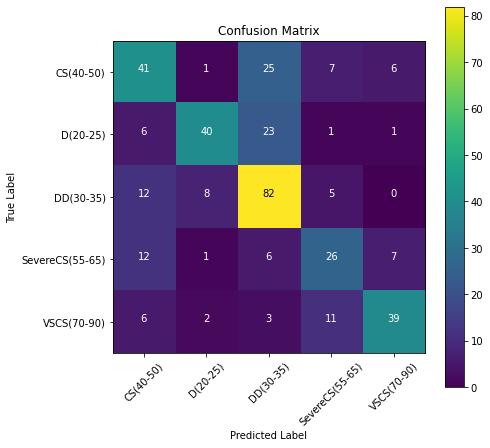

In [ ]:
clf_report(true_value, own_model_pred)

# **Visualise Feature Maps**

In [29]:
model = load_model('/content/drive/MyDrive/multiclass_own_model.hdf5')

In [30]:
model.layers

In [31]:
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [32]:
import glob, random
#file_path_type = ["/content/drive/MyDrive/train/VSCS(70-90)/*.jpg"]
#images = glob.glob(random.choice(file_path_type))
#img_path = random.choice(images)

In [33]:
img_path = '/content/drive/MyDrive/cyclone_testing/20220507.12-30.jpg'

1/1 [==============================] - 7s 7s/step


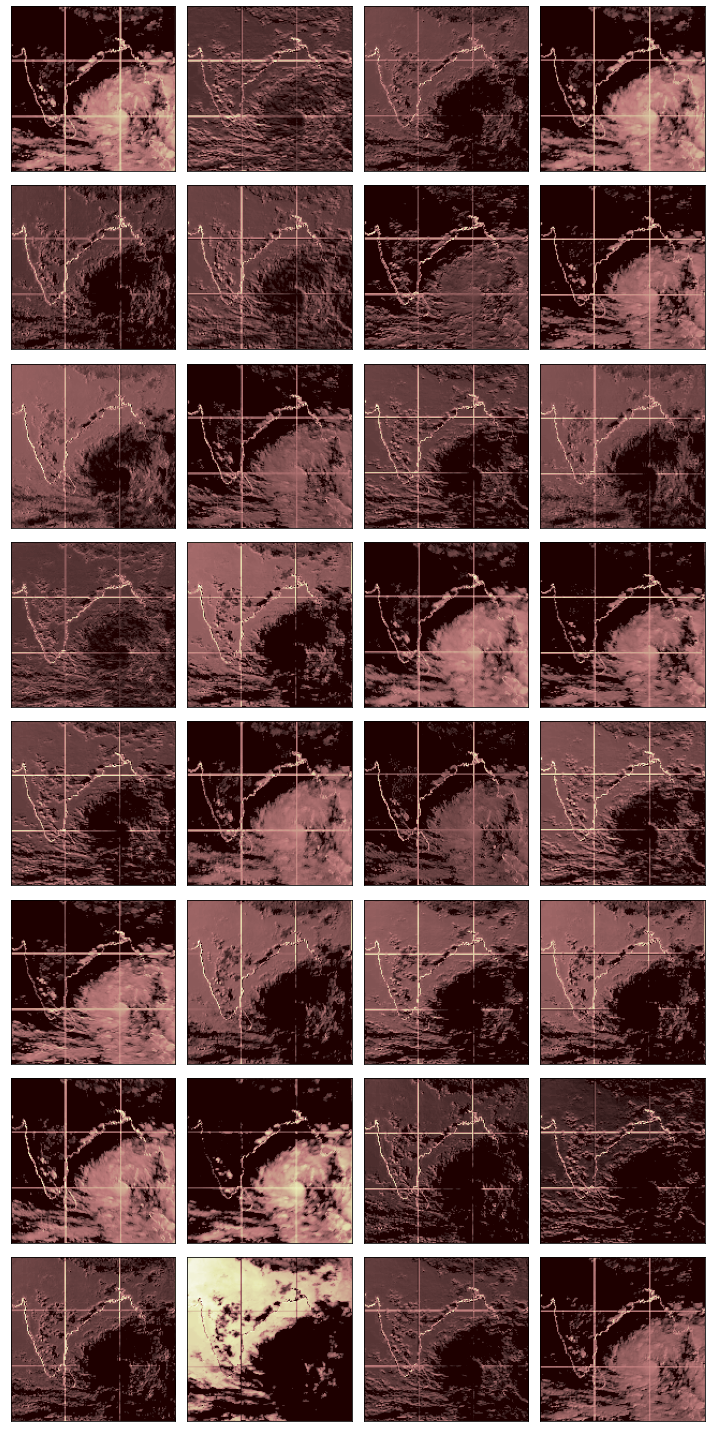

In [34]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from numpy import expand_dims

# redefine model to output right after the first hidden layer
model = Model(inputs = model.inputs, outputs = model.layers[1].output)
img = load_img(img_path, target_size = (310, 310))

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis = 0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 32 maps in an 8x8 squares
rows = 8
columns = 4
ix = 1
plt.figure(figsize=(10, 20))
for _ in range(rows):
    for _ in range(columns):
        # specify subplot and turn of axis
        ax = plt.subplot(rows, columns, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap = 'pink')
        ix += 1
plt.tight_layout()
plt.savefig("Feature Maps" + ".jpg", transparent = True, bbox_inches = 'tight')
plt.show()

# **Ensemble Model**

In [ ]:
vgg_best_model = load_model('/content/drive/MyDrive/multiclass_vgg_model.hdf5')
resnet_best_model = load_model('/content/drive/MyDrive/multiclass_resnet_model.hdf5')
inception_best_model = load_model('/content/drive/MyDrive/multiclass_inception_model.hdf5', custom_objects = {'f1':f1})
own_best_model = load_model('/content/drive/MyDrive/multiclass_own_model.hdf5', custom_objects = {'f1':f1})

In [ ]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
own_model_pred = []
for folder in os.listdir(val_folders):
    
    test_image_ids = os.listdir(os.path.join(val_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(val_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255
        
        #vgg16
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)
        
        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

        #own
        own_model_prediction = np.argmax(own_best_model.predict(np.array([img_normalized])))
        own_model_pred.append(own_model_prediction)
        
        #giving own model high priority if they all predict something different
        image_prediction = mode([own_model_prediction,  resnet_50_image_prediction, inception_image_prediction, vgg16_image_prediction])                                
        combined_model_pred.append(image_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize = (7, 7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.6576819407008087
                 precision    recall  f1-score   support

      CS(40-50)       0.61      0.61      0.61        80
       D(20-25)       0.77      0.65      0.70        71
      DD(30-35)       0.63      0.73      0.68       107
SevereCS(55-65)       0.56      0.52      0.54        52
    VSCS(70-90)       0.75      0.72      0.73        61

       accuracy                           0.66       371
      macro avg       0.66      0.65      0.65       371
   weighted avg       0.66      0.66      0.66       371



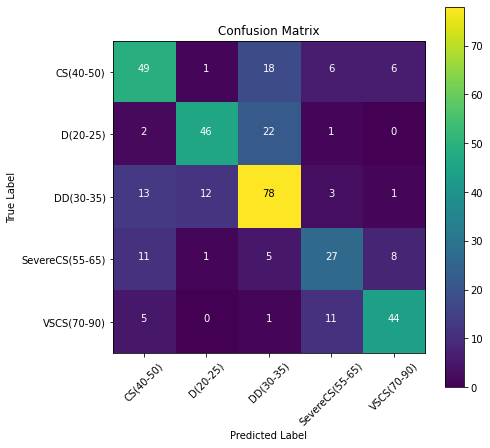

In [ ]:
combined_model_pred = [c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)